In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [4]:
l = pd.read_csv('data/raw/Poland_lab.csv')
s = pd.read_csv('data/raw/Poland_spc.csv')

In [5]:
l.head()

,Unnamed: 0,SAMPLE_ID,CLAY,SILT,SAND,SOC,CaCO3,N,P,K,CEC,GPS_PROJ,GPS_LAT,GPS_LONG,LC1,LC2,LU1,LU2,MINERAL,COUNTRY
0,1,15844,5.0,19.0,77.0,7.7,1,0.9,47.2,151.6,2.8,WGS84,52.22599,16.66950,B32,8,U111,8,mineral,POLAND
1,2,15848,3.0,16.0,81.0,7.9,0,0.9,35.9,74.9,2.2,WGS84,52.15771,16.60046,B13,8,U111,8,mineral,POLAND
2,3,15849,2.0,2.0,96.0,4.4,0,0.6,44.6,24.7,2.5,WGS84,52.12030,16.62426,C20,8,U120,8,mineral,POLAND
3,4,15850,3.0,13.0,84.0,19.1,2,0.8,14.5,34.3,6.0,WGS84,52.21268,15.90345,C20,8,U120,8,mineral,POLAND
4,5,15851,12.0,15.0,73.0,20.6,18,1.8,30.1,145.1,16.1,WGS84,52.15596,15.95454,B13,8,U111,8,mineral,POLAND


In [6]:
s.head()

,Unnamed: 0,500,502,504,506,508,510,512,514,516,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,15844,0.181133,0.182503,0.183902,0.185339,0.186789,0.188266,0.189757,0.191274,0.192803,...,0.407736,0.407486,0.407278,0.407092,0.406922,0.406797,0.406709,0.406624,0.406560,0.406530
1,15848,0.139273,0.140306,0.141367,0.142463,0.143574,0.144710,0.145860,0.147030,0.148216,...,0.391916,0.391580,0.391287,0.391051,0.390835,0.390645,0.390499,0.390397,0.390341,0.390369
2,15849,0.126510,0.127314,0.128139,0.128994,0.129865,0.130754,0.131651,0.132565,0.133493,...,0.390415,0.390037,0.389697,0.389382,0.389093,0.388843,0.388623,0.388436,0.388312,0.388280
3,15850,0.142304,0.143086,0.143884,0.144708,0.145544,0.146401,0.147267,0.148151,0.149056,...,0.375383,0.374992,0.374628,0.374319,0.374069,0.373841,0.373631,0.373460,0.373336,0.373238
4,15851,0.081969,0.082347,0.082734,0.083139,0.083554,0.083981,0.084414,0.084858,0.085314,...,0.281194,0.280594,0.280016,0.279475,0.278968,0.278498,0.278078,0.277695,0.277356,0.277055


Testing for "organic" soils:

In [7]:
np.count_nonzero(l['MINERAL'] == 'organic')

46

Drop them:

In [8]:
l_only_mineral = l[l['MINERAL'] != 'organic']
s_only_mineral = s[l['MINERAL'] != 'organic']
len(l_only_mineral), len(s_only_mineral)

(1568, 1568)

Before sampling, estimate distribution:

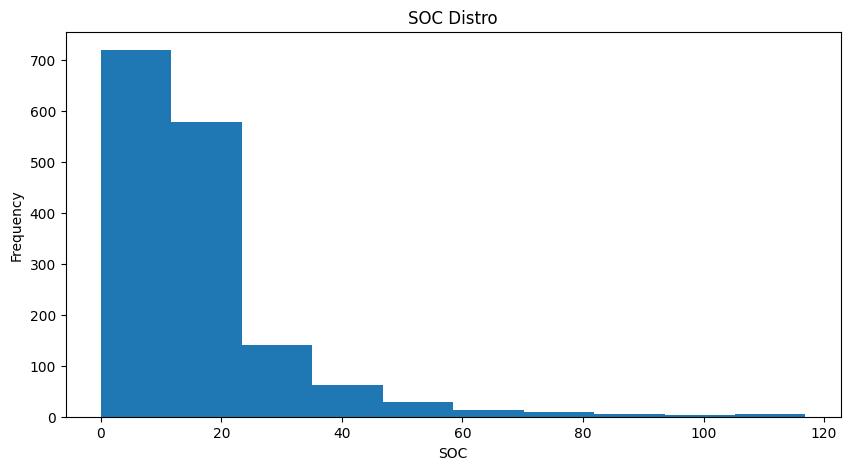

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(l_only_mineral['SOC'])
plt.title('SOC Distro')
plt.xlabel('SOC')
plt.ylabel('Frequency')
plt.show()

Now estimate distro of X in PC1 PC2 space:

Text(0, 0.5, 'PC2')

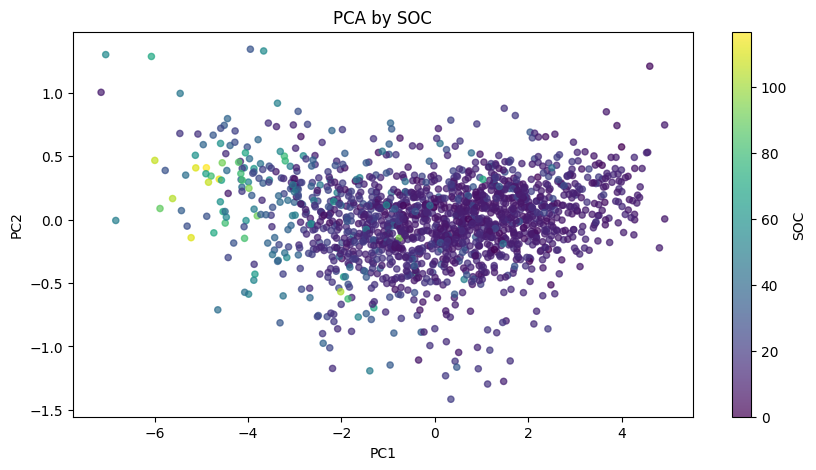

In [10]:
plt.figure(figsize=(10, 5))
pca = PCA(n_components=2)
l_pca = pca.fit_transform(s_only_mineral.values[:, 1:])


plt.scatter(l_pca[:, 0], l_pca[:, 1], s=20, c=l_only_mineral['SOC'], cmap='viridis', alpha=0.7)
plt.colorbar(label='SOC')
plt.title('PCA by SOC')
plt.xlabel('PC1')
plt.ylabel('PC2')

We see the heavy disbalance and some "periphery" samples. Let us try the KS sampling:

In [11]:
import kennard_stone as ks
X_train, X_test, y_train, y_test = ks.train_test_split(s_only_mineral.values[:, 1:], l_only_mineral['SOC'].values, test_size = 0.25)

2026-02-21 12:47:49,606 - kennard_stone.utils._pairwise:114[INFO] - Calculating pairwise distances using scikit-learn.

2026-02-21 12:47:49,654 - kennard_stone.utils._pairwise:114[INFO] - Calculating pairwise distances using scikit-learn.



[]

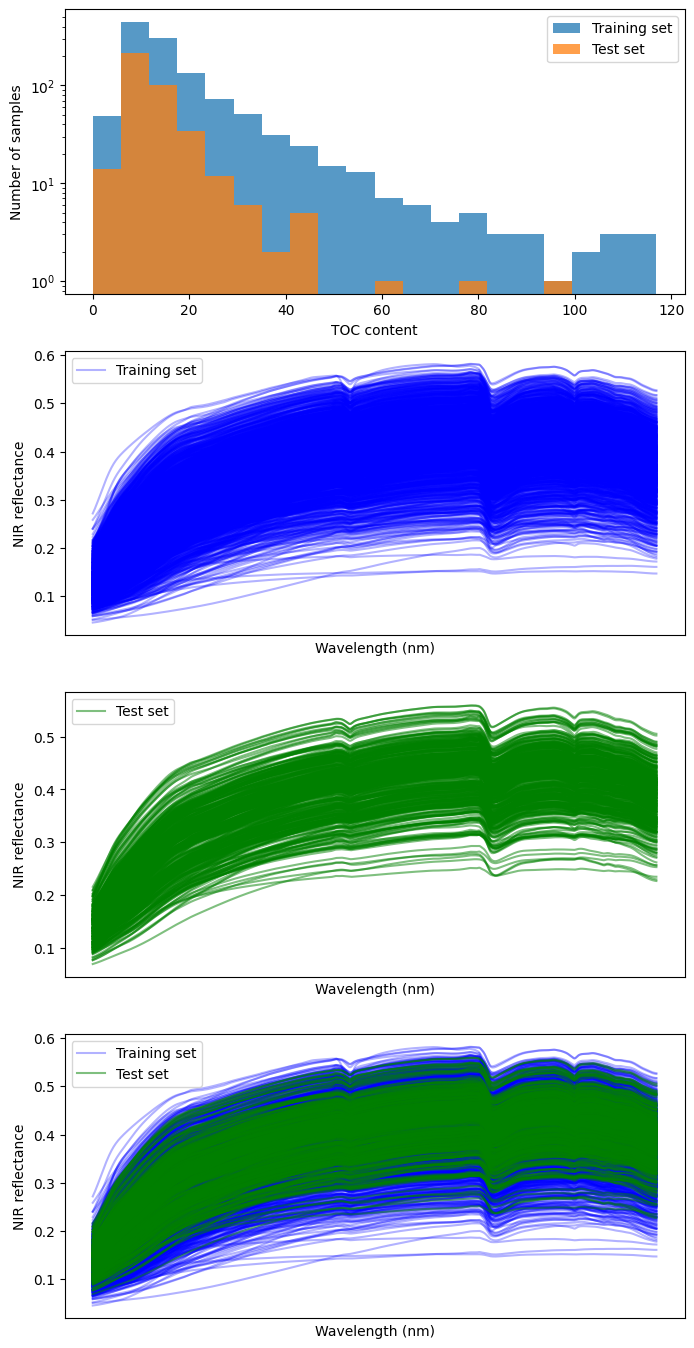

In [12]:
# adopted from https://nirpyresearch.com/kennard-stone-algorithm/
f, axs = plt.subplots(4,1,figsize=(8,17))
n, bins, patches = axs[0].hist(y_train, bins = 20, alpha=0.75, label="Training set")
axs[0].hist(y_test, bins = bins, alpha=0.75, label="Test set", log=True)
axs[0].legend()
axs[0].set_xlabel("TOC content")
axs[0].set_ylabel("Number of samples")

train_legend =  np.repeat("_Training set", X_train.shape[0])
train_legend[0] = "Training set"
test_legend =  np.repeat("_Test set", X_test.shape[0])
test_legend[0] = "Test set"

axs[1].plot(s.columns[1:].values, X_train.T, 'b', alpha=0.3, label = train_legend)
axs[1].legend()
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("NIR reflectance")
axs[1].set_xticks([])

axs[2].plot(s.columns[1:].values, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[2].legend()
axs[2].set_xlabel("Wavelength (nm)")
axs[2].set_ylabel("NIR reflectance")
axs[2].set_xticks([])


axs[3].plot(s.columns[1:].values, X_train.T, 'b', alpha=0.3, label = train_legend)
axs[3].plot(s.columns[1:].values, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[3].legend()
axs[3].set_xlabel("Wavelength (nm)")
axs[3].set_ylabel("NIR reflectance")
axs[3].set_xticks([])

It's satisfactory but the test set lackes high TOC samples. Let us fix it with stratified sampling:

In [13]:
bins = np.quantile(l_only_mineral['SOC'].values, np.linspace(0, 1, 20))
y_binned = np.digitize(l_only_mineral['SOC'].values, bins[1:-1])

X_train, X_test, y_train, y_test = train_test_split(
    s_only_mineral.values[:, 1:], l_only_mineral['SOC'].values,
    test_size=0.2,
    stratify=y_binned,
    random_state=42
)

In [14]:
y_test.shape

(314,)

[]

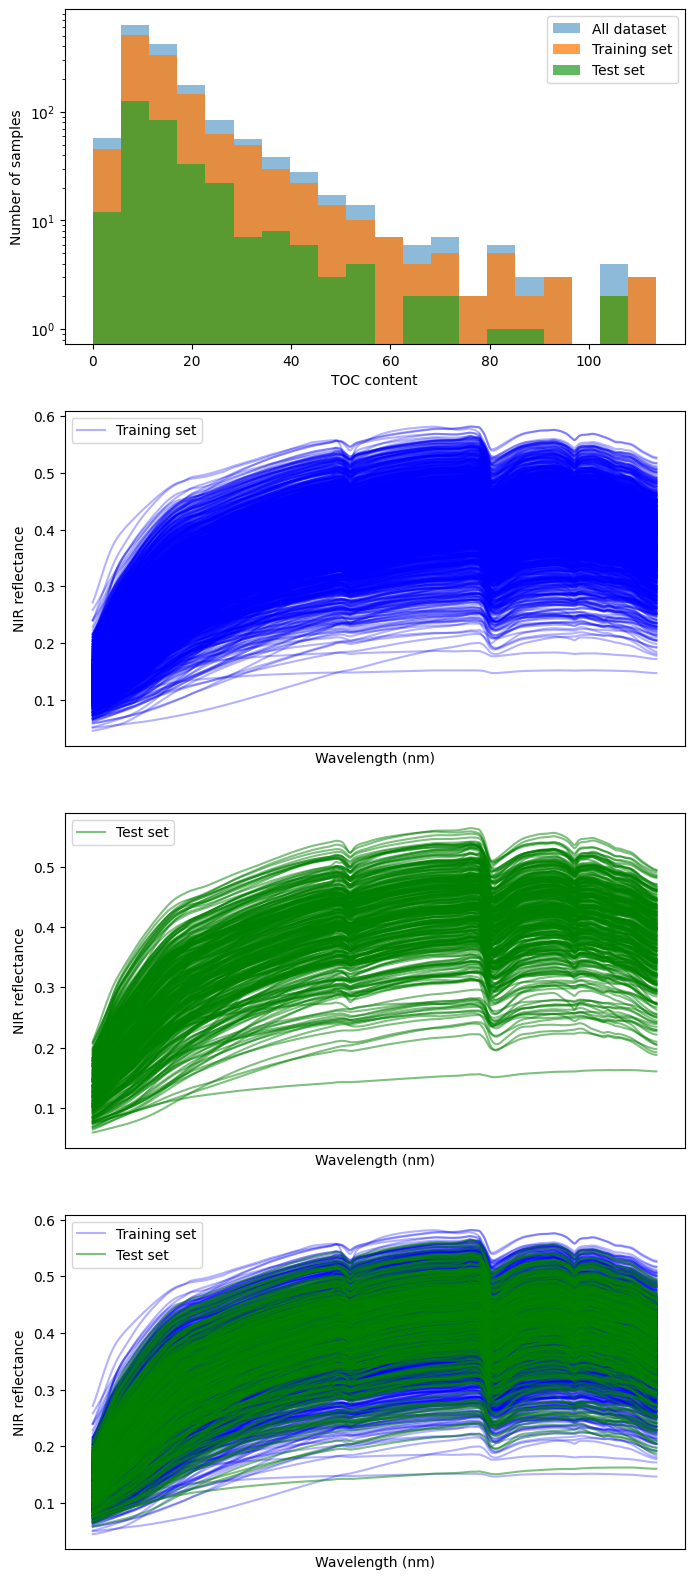

In [ ]:
# adopted from https://nirpyresearch.com/kennard-stone-algorithm/
f, axs = plt.subplots(4,1,figsize=(8,20))
n, bins, patches = axs[0].hist(np.concatenate((y_train, y_test)), bins = bins, alpha=0.5, label="All dataset", log=True)
axs[0].hist(y_train, bins = bins, alpha=0.75, label="Training set", log=True)
axs[0].hist(y_test, bins = bins, alpha=0.75, label="Test set", log=True)
axs[0].legend()
axs[0].set_xlabel("TOC content")
axs[0].set_ylabel("Number of samples")

train_legend =  np.repeat("_Training set", X_train.shape[0])
train_legend[0] = "Training set"
test_legend =  np.repeat("_Test set", X_test.shape[0])
test_legend[0] = "Test set"

axs[1].plot(s.columns[1:].values, X_train.T, 'b', alpha=0.3, label = train_legend)
axs[1].legend()
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("NIR reflectance")
axs[1].set_xticks([])

axs[2].plot(s.columns[1:].values, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[2].legend()
axs[2].set_xlabel("Wavelength (nm)")
axs[2].set_ylabel("NIR reflectance")
axs[2].set_xticks([])


axs[3].plot(s.columns[1:].values, X_train.T, 'b', alpha=0.3, label = train_legend)
axs[3].plot(s.columns[1:].values, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[3].legend()
axs[3].set_xlabel("Wavelength (nm)")
axs[3].set_ylabel("NIR reflectance")
axs[3].set_xticks([])

Now it's better.

[]

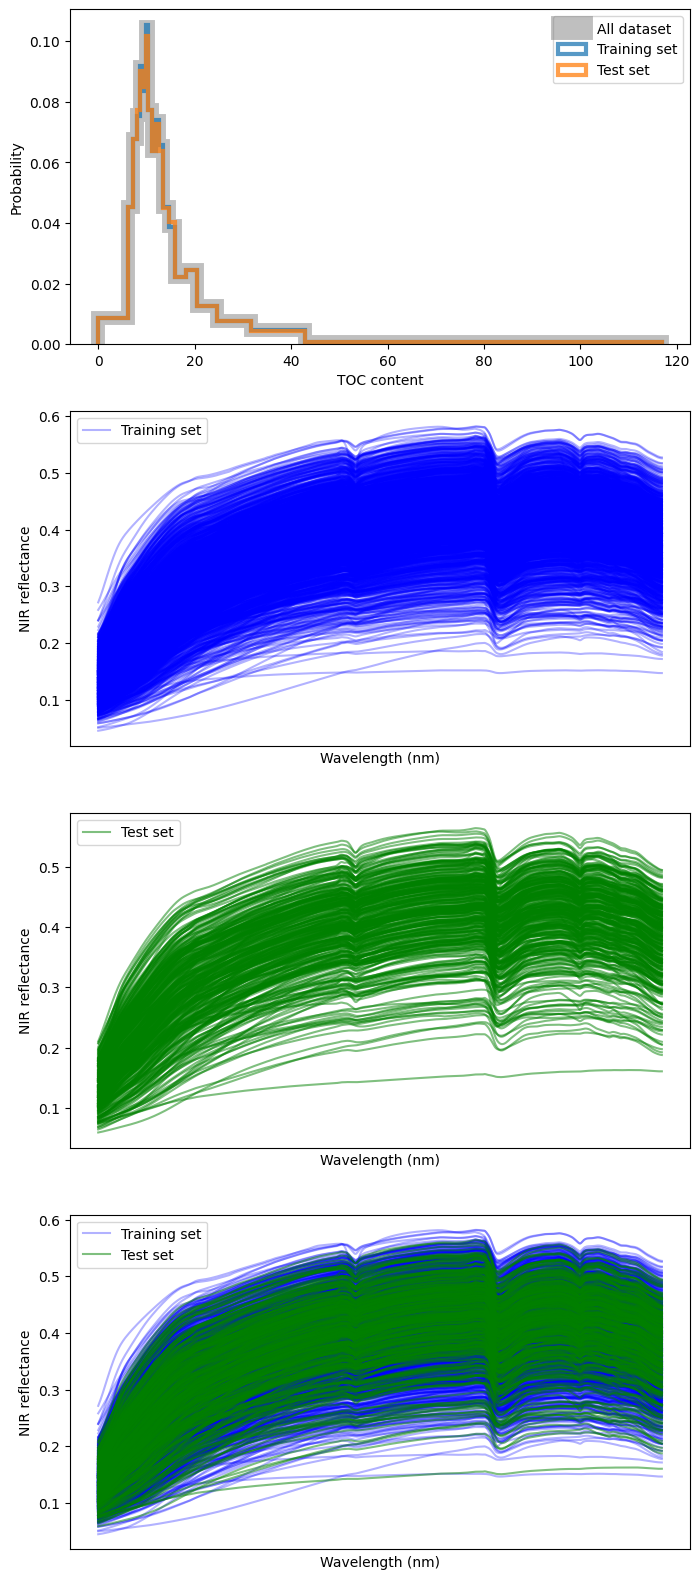

In [22]:
# adopted from https://nirpyresearch.com/kennard-stone-algorithm/
f, axs = plt.subplots(4,1,figsize=(8,20))
n, bins, patches = axs[0].hist(np.concatenate((y_train, y_test)), bins = bins,
                    alpha=0.5, label="All dataset", density=True,
                    histtype='step', linewidth=10, color='gray',)

axs[0].hist(y_train, bins = bins, alpha=0.75, label="Training set", density=True, histtype='step', linewidth=3)
axs[0].hist(y_test, bins = bins, alpha=0.75, label="Test set", density=True, histtype='step', linewidth=3)
axs[0].legend()
axs[0].set_xlabel("TOC content")
axs[0].set_ylabel("Probability")

train_legend =  np.repeat("_Training set", X_train.shape[0])
train_legend[0] = "Training set"
test_legend =  np.repeat("_Test set", X_test.shape[0])
test_legend[0] = "Test set"

axs[1].plot(s.columns[1:].values, X_train.T, 'b', alpha=0.3, label = train_legend)
axs[1].legend()
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("NIR reflectance")
axs[1].set_xticks([])

axs[2].plot(s.columns[1:].values, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[2].legend()
axs[2].set_xlabel("Wavelength (nm)")
axs[2].set_ylabel("NIR reflectance")
axs[2].set_xticks([])


axs[3].plot(s.columns[1:].values, X_train.T, 'b', alpha=0.3, label = train_legend)
axs[3].plot(s.columns[1:].values, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[3].legend()
axs[3].set_xlabel("Wavelength (nm)")
axs[3].set_ylabel("NIR reflectance")
axs[3].set_xticks([])

In [ ]:
import numpy as np

np.savez_compressed(
    "data/dataset_splits.npz",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

In [ ]:
X_train.shape, X_test.shape

((1254, 1000), (314, 1000))

In [95]:
y_train.shape, y_test.shape

((1254,), (314,))

todo:

y_log = np.log1p(y)